# Fitting a weight function to the Lamb-Oseen vortex

We assume that the Biot-Savart law can be written with a weight function like
$$
\vec u_w (\vec r) = \frac{\Gamma}{4 \pi} \oint_C \frac{\hat t \times \vec \xi(\ell)}{\|\vec \xi (\ell)\|^3} w\left(\tfrac{\Delta}{a}\right) d\ell
$$
where $a$ is the vortex core radius, $\vec \xi (\ell) = \vec r - \vec C(\ell)$ is the vector from $\vec C(\ell)$ to $\vec r$, $\Delta$ is some measure (chosen by us) of the distance between $\vec r$ and $\vec C(\ell)$, and $w$ is a weight function which is assumed to be zero when $\Delta = 0$ and one when $\Delta = \alpha a$ with $\alpha$ being an integer constant selected based on the problem.

**We want to fit our weight function such that when given a Lamb-Oseen vortex, we can recover the correct velocity field.** That is, $w\, | \, \vec u_w \approx \vec u_{LO}$

The velocity field of Lamb-Oseen vortex in cylindrical coordinates is given by
$$
\vec u_{LO}(s, \phi, z) = \frac{\Gamma}{2 \pi s} \left(1 - e^{-s^2 / 2 a^2}\right) \hat \phi
$$

## Simplifying the Problem

Consider the Lamb-Oseen vortex be aligned with the $x$-axis and where $\Gamma = 1$ and $a = 1$.

The vortex is infinitely long, so $\vec u_{LO}$ is the same for any $z$, therefore we can set $z=0$ without loss of generality. The vortex also has axial symmetry, so we can set $\phi=0$, i.e., we evaluate the velocity only along the $y$-axis. Then the velocity will always be in the $\hat z$ direction, so we only evaluate the $z$-component of the velocity.

We will assume that $\Delta$ depends on the radial distance $\vec \xi$ like
$$
\Delta \equiv \| \vec \xi \|^2
$$
and that $a = 1$.

With the above we get
$$
\begin{align}
\ell &= x \\
\vec r &= y \hat y \\
\hat t &= \hat x \\
\vec C(x) &= x \hat x \\
\vec \xi(x) &= y \hat y - x \hat x \\
\|\vec \xi(x)\|^2 &= y^2 + x^2 \\
\hat x \times \vec \xi(x) &= y \hat z
\end{align}
$$
so we can rewrite the Bio-Savart law as
$$
u_w(y) = \frac{1}{4 \pi} \int_{-\infty}^\infty \frac{y}{(y^2 + x^2)^{3/2}} w\left(y^2 + x^2\right) dx
$$

When $w = 1$, we can evaluate the integral exactly as
$$
u_{w=1}(y) = \frac{1}{4 \pi} \frac{x}{y \sqrt{x^2 + y^2}} \Big|_{-\infty}^\infty = \frac{1}{2 \pi y} 
$$
where we assumed that $y > 0$ (i.e., real and positive). This is the expected result for an infinitesimally thin vortex filament. 

The velocity of the Lamb-Oseen vortex is
$$
u_{LO}(y) = \frac{1}{2 \pi y} \left(1 - e^{-y^2/2}\right)
$$



In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
def u_LO(y):
    return (1 - np.exp(-y**2/2)) / (2 * np.pi * y)

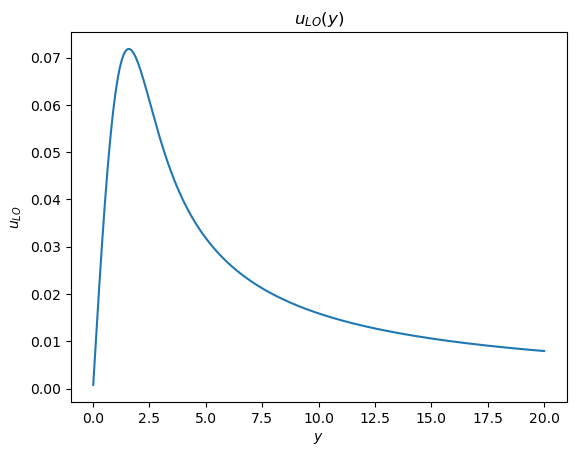

In [3]:
y_vec = np.linspace(0.01, 20, 1000)
u_LO_vec = u_LO(y_vec)
plt.plot(y_vec, u_LO_vec)
plt.title('$u_{LO}(y)$')
plt.xlabel('$y$')
plt.ylabel('$u_{LO}$')
plt.show()

## Weight Function

We will model the weight function as Bernstein polynomial, however, any other polynomial basis could be used.

A Bernstein polynomial of degree $n$ is given by
$$
B_n (x) = \sum_{k=0}^n \beta_k b_{k, n}(x)
$$
where \beta_k are the Bernstein coefficients (i.e., the coefficients we need to fit) and $b_{k, n}(x)$ are the Bernstein basis polynomials given by
$$
b_{k, n}(x) = \binom{n}{k} x^k (1 - x)^{n-k},\quad k = 0, 1, \ldots, n
$$
where $\binom{n}{k} = n!/k!(n-k)!$ is the binomial coefficient. Note, for a Bernstein polynomial of degree $n$, there are $n+1$ Bernstein basis polynomials.

**De Casteljau's algorithmt** is a numerically stable, recursive, algorithm for computing the Bernstein basis polynomials.

A Bernstein polynomial of degree $n$ can be evaluated at $x_0$ with the following
$$
\begin{align}
\alpha_i^{(0)} &= \beta_i && r=0; && i=0, \dots, n\\
\alpha_i^{(r)} &= \alpha_i^{(r-1)}(1-x_0) + \alpha_{i+1}^{(r-1)} x_0 && r=0,\dots,n; && i=0,\dots,n-r
\end{align}
$$
where $i$ indexes the control points and $r$ level of recurrence. $\beta_i$ is the $i$-th Bernstein coefficient.

The result $B(x_0)$ is given by
$$
B_n(x_0) = \alpha_0^{(n)}
$$
that is, the $n$-th recurrence of the $0$-th control point.

**The Implementation of De Casteljau's algorithm** will compute the recurrence levels in descending order and the control points in ascending order. That is, we start with $r = n$ and $i = 0$ and end with $r = 0$ and $i = n$.

In [4]:
class BernsteinPolynomial:
    def __init__(self, order, cutoff, w0=None, wN=None):
        self.order = int(order)
        # Initialize the weights to all ones
        self.weights = np.ones(order + 1)
        # print('(DEBUG: BP class) self.weights (1) =', self.weights)
        
        if w0 is not None:
            self.w0 = w0
            try:
                len(w0)
            except TypeError:
                self.len_w0 = None
                self.weights[0] = w0
            else:
                self.len_w0 = len(w0)
                self.weights[:self.len_w0] = w0
        else:
            self.w0 = None
        
        if wN is not None:
            self.wN = wN
            try:
                len(wN)
            except TypeError:
                self.len_wN = None
                self.weights[-1] = wN
            else:
                self.len_wN = len(wN)
                self.weights[-self.len_wN:] = wN
        else:
            self.wN = None
    
    # def __repr__(self):
    #     return f'BernsteinPolynomial({self.weights})'
    
    def set_weights(self, weights):
        order = len(weights) - 1
        if order != self.order:
            raise ValueError('The order of the weights does not match the order of the Bernstein polynomial.')
        else:
            self.weights = weights
            
            if self.w0 is not None:
                if self.len_w0 is None:
                    self.weights[0] = self.w0
                else:
                    self.weights[:self.len_w0] = self.w0
            
            if self.wN is not None:
                if self.len_wN is None:
                    self.weights[-1] = self.wN
                else:
                    self.weights[-self.len_wN:] = self.wN
        
        
        # print('(DEBUG: BP class) self.weights (2) =', self.weights)
        self.order = len(weights) - 1
    
    def __call__(self, x0):
        try:
            len(x0)
        except TypeError:
            alpha = np.zeros((self.order + 1, self.order + 1))
        else:
            alpha = np.zeros((self.order + 1, self.order + 1, len(x0)))
        finally:
            # -1 because range does not include the last value
            for i in range(self.order, -1, -1):
                # print('(DEBUG) i =', i)
                # + 1 because range does not include the last value
                for r in range(0, self.order - i + 1):
                    # print('(DEBUG) r =', r)
                    if r == 0:
                        try:
                            alpha[r, i] = self.weights[i]
                        except Exception as exc:
                            # print(exc)
                            print('r =', r)
                            print('i =', i)
                            print('weights[i] =', self.weights[i])
                            raise exc
                    
                    else:
                        try:
                            alpha[r, i] = alpha[r - 1, i] * (1 - x0) + alpha[r-1, i + 1] * x0
                        except Exception as exc:
                            # print(exc)
                            print('r =', r)
                            print('i =', i)
                            print('alpha[r - 1, i] =', alpha[r - 1, i])
                            print('alpha[r - 1, i + 1] =', alpha[r - 1, i + 1])
                            print('x0 =', x0)
                            raise exc
            
            # print('(DEBUG) alpha =\n', alpha)
            return alpha[self.order, 0]           

In [5]:
bp = BernsteinPolynomial(4)
bp(0.5)

1.0

## Validating our Bernstein Polynomial Implementation

A Bernstein polynomial of degree $n$ is given by
$$
B_n (x) = \sum_{k=0}^n \beta_k b_{k, n}(x)
$$
Then the first $n=0, 1, 2, 3$ Bernstein polynomials are
$$
\begin{align}
B_0(x) &= \beta_0 \\
B_1(x) &= \beta_0 (1 - x) + \beta_1 x \\
B_2(x) &= \beta_0 (1 - x)^2 + \beta_1 \cdot 2x(1-x) + \beta_2 x^2 \\
B_3(x) &= \beta_0 (1 - x)^3 + \beta_1 \cdot 3x (1 - x)^2 + \beta_2 \cdot 3 x^2 (1 - x) + \beta_3 x^3 \\
B_4(x) &= \beta_0 (1 - x)^4 + \beta_1 \cdot 4x (1 - x)^3 + \beta_2 \cdot 6 x^2 (1 - x)^2 + \beta_3 \cdot 4 x^3 (1 - x) + \beta_4 x^4
\end{align}
$$


In [6]:
def BP2(x, beta):
    return beta[0] * (1 - x)**2 + beta[1] * 2 * x * (1 - x) + beta[2] * x**2

def BP4(x, beta):
    return beta[0] * (1 - x)**4 + beta[1] * 4 * x * (1 - x)**3 + beta[2] * 6 * x**2 * (1 - x)**2 + beta[3] * 4 * x**3 * (1 - x) + beta[4] * x**4

In [7]:
beta = np.arange(5)
x0 = 0.12
print(BP4(x0, beta))

0.48000000000000004


Error = 9.209666375651935e-16


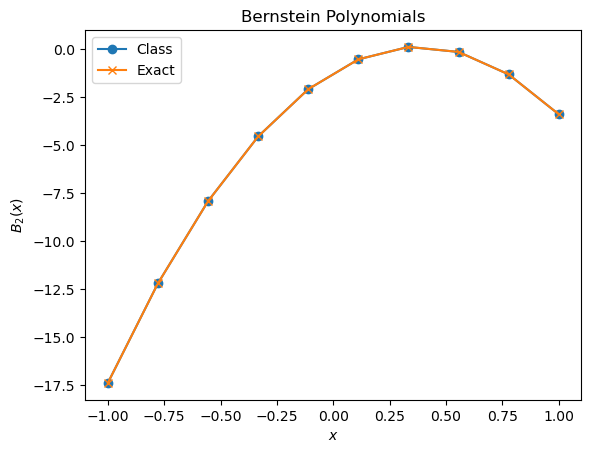

In [8]:
order = 2
x_vec = np.linspace(-1, 1, 10)
beta = [-1.2, 2.3, -3.4]
bp = BernsteinPolynomial(order)
bp.set_weights(beta)
y_vec = np.array([bp(x) for x in x_vec])
y_vec_exact = BP2(x_vec, beta)
print('Error =', np.linalg.norm(y_vec - y_vec_exact))
plt.plot(x_vec, y_vec, 'o-', label='Class')
plt.plot(x_vec, y_vec_exact, 'x-', label='Exact')
plt.legend()
plt.title('Bernstein Polynomials')
plt.xlabel('$x$')
plt.ylabel('$B_2(x)$')
plt.show()

beta = [-4.85558223  7.2078709   0.5355513  -4.21785404  2.21962931]
Error = 3.1778182645451764e-14


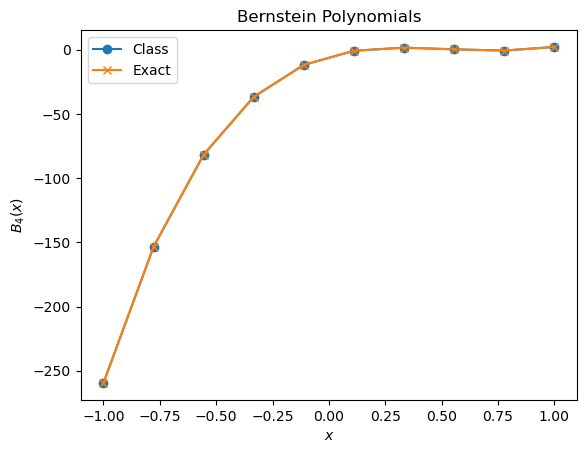

In [9]:
order = 4
x_vec = np.linspace(-1, 1, 10)
beta = np.random.default_rng().uniform(-10, 10, order + 1)
print('beta =', beta)
bp = BernsteinPolynomial(order)
bp.set_weights(beta)
# y_vec = np.array([bp(x) for x in x_vec])
y_vec = bp(x_vec)
y_vec_exact = BP4(x_vec, beta)
print('Error =', np.linalg.norm(y_vec - y_vec_exact))
plt.plot(x_vec, y_vec, 'o-', label='Class')
plt.plot(x_vec, y_vec_exact, 'x-', label='Exact')
plt.legend()
plt.title('Bernstein Polynomials')
plt.xlabel('$x$')
plt.ylabel('$B_4(x)$')
plt.show()

[ 0.         -0.52033582  0.40819677  0.02110811 -0.74832292  0.5580953
 -0.46603352  1.        ]


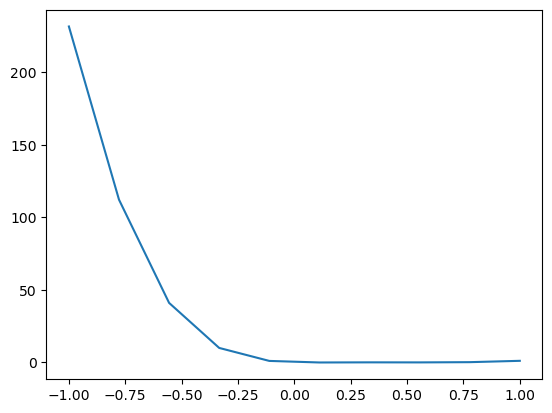

In [10]:
order = 7
bp = BernsteinPolynomial(order, w0=0, wN=1)
bp.set_weights(np.random.default_rng().uniform(-1, 1, order + 1))
print(bp.weights)
x_vec = np.linspace(-1, 1, 10)
y_vec = bp(x_vec)
plt.plot(x_vec, y_vec)
plt.show()

## Validating method for integrating the Bio-Savart law

Consider an infinitely long infinitesimally thin vortex filament aligned with the $x$-axis. The velocity field is given by
$$
\vec u_{0true}(y) = \frac{1}{2 \pi y} \hat z
$$
where $y$ is the distance from the vortex filament.

The Biot-Savart law is the same as before except we set the weight function to one, i.e., $w = 1$, thus
$$
u_{w=1}(y) = \frac{1}{4 \pi} \int_{-\infty}^\infty \frac{y}{(y^2 + x^2)^{3/2}} dx
$$

In [11]:
# Unweighted Bio-Savart law for testing integration method
def u_0(y):
    def integrand(x, y):
        # x & y can be floats or arrays
        return y /  (y**2 + x**2)**(3/2)
        
    # Integration by scipy.integrate.quad
    return sp.integrate.quad(integrand, -np.inf, np.inf, args=(y))[0] / (4 * np.pi)
        


Error = 1.422726685315479e-13


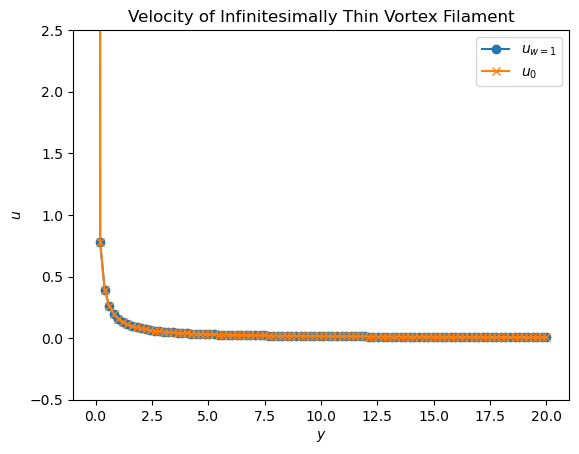

In [12]:
y_vec = np.linspace(0.001, 20, 100)
u_0true_vec = 1 / (2 * np.pi * y_vec)
u_0_vec = []
for i in range(len(y_vec)):
    u_0_vec.append(u_0(y_vec[i]))

u_0_vec = np.array(u_0_vec)

print('Error =', np.linalg.norm(u_0_vec - u_0true_vec))

plt.plot(y_vec, u_0_vec, 'o-', label='$u_{w=1}$')
plt.plot(y_vec, u_0true_vec, 'x-', label='$u_0$')
plt.legend()
plt.title('Velocity of Infinitesimally Thin Vortex Filament')
plt.xlabel('$y$')
plt.ylabel('$u$')
plt.ylim([-.5, 2.5])
plt.show()

## Validating the fitting method

In [13]:
theta_vec = np.linspace(0, 2 * np.pi, 50)
x_vec = np.cos(theta_vec)

order = 7
bp = BernsteinPolynomial(order)

def fit_loop(x0, *weights):
    bp.set_weights(weights)
    return bp(x0)

p0 = np.ones(order + 1)
# p0 = np.random.default_rng().uniform(-10, 10, order + 1)
opw = sp.optimize.curve_fit(fit_loop, theta_vec, x_vec, p0=p0)[0]
print('opw =', opw)
print('bp.weights =', bp.weights)
x_vec_fit = bp(theta_vec)

opw = [1.0019115  0.99728324 0.97348118 0.9272577  0.85839148 0.76880649
 0.66183117 0.54159781]
bp.weights = (1.001911503522665, 0.9972832366550443, 0.9734811839369856, 0.9272576995299343, 0.8583914762404693, 0.7688064900839993, 0.6618311724779955, 0.5415978081344521)


Error = 0.006911075559092699


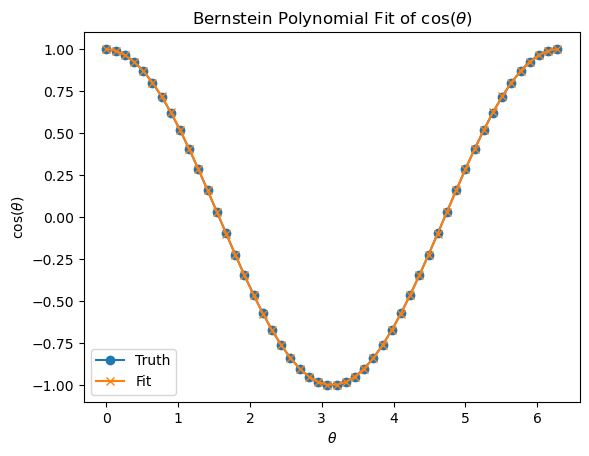

In [14]:
print('Error =', np.linalg.norm(x_vec_fit - x_vec))

plt.plot(theta_vec, x_vec, 'o-', label='Truth')
plt.plot(theta_vec, x_vec_fit, 'x-', label='Fit')
plt.legend()
plt.title('Bernstein Polynomial Fit of $\cos(\\theta)$')
plt.xlabel('$\\theta$')
plt.ylabel('$\cos(\\theta)$')
plt.show()

## Fitting the Weight Function

We will use `scipy.optimize.curve_fit` to fit the weight function.

Using the variable names from the documentation (see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)):
- ~~`f` is the function we want to fit, i.e., the weighted Biot-Savart law~~
- ~~`xdata` is an array of the independent variables where the data is measured, i.e., values of $y$ given to the weighted Biot_Savart law~~
- ~~`ydata` is an array of the data we want to fit our function to, i.e., the velocity of the Lamb-Oseen vortex in the $\hat z$ direction.~~
- ~~`p0` is an initial guess for the parameters of the function we want to fit. We should not need to provide this because the number of parameters is determined when the weight function is initialized.~~

The weighted Biot-Savart law for an infinitely long infinitesimally thin vortex filament aligned with the $x$-axis is given by
$$
u_w(y) = \frac{1}{4 \pi} \int_{-\infty}^\infty \frac{y}{(y^2 + x^2)^{3/2}} w\left(y^2 + x^2\right) dx
$$
However, we only need to evaluate the weighted Biot-Savart law when we are in, on, or very near the vortex core, otherwise, we can use the unweighted Biot-Savart law. Therefore, we will set up the fitting problem so the weighted Biot-Savart law is only evaluated when $y < a_{co}$ where $a_{co}$ is some cutoff radius (which we determine from testing) and evaluate the unweighted Biot-Savart law otherwise.

We can evaluate the unweighted Biot-Savart law exactly (using Mathematica) from some cutoff radius $a_{co}$ to infinity as
$$
u_{w=1}(y) = \frac{1}{2 \pi} \left(\frac{1}{y} - \frac{a_{co}}{y \sqrt{a_{co}^2 + y^2}}\right)
$$

In [23]:
# Bio-Savart law with Bernstein polynomial weight function
def u_w(y, *weights):
    w0 = [0, 0]
    wN = [1, 1, 1]
    w = np.concatenate([w0, weights, wN])
    order = len(w) - 1
    wf = BernsteinPolynomial(order)
    wf.set_weights(w)
    
    try:
        len(y)
    except TypeError:  # y is not a sequence
        def integrand(x):
            # x & y can be floats or arrays
            mag_xi = np.sqrt(y**2 + x**2)
            return y * wf(mag_xi) /  mag_xi**3
        
        a_co = 5
        if y < a_co:  # inside cutoff radius
            # sol = 2 * sp.integrate.quad(integrand, 0, a_co)[0] + (2 / y) - (2 * np.sqrt(a_co**2 + y**2) / (y * a_co))
            sol = 2 * sp.integrate.quad(integrand, 0, a_co)[0] + (2 / y) - (2 * a_co / (y * np.sqrt(a_co**2 + y**2)))
        else:  # outside the cutoff radius, use unweighted BS law
            sol = 2 / y
            
        return sol / (4 * np.pi)
    else: # y is a sequence
        u_w_vec = []
        for i in range(len(y)):
            u_w_vec.append(u_w(y[i], *weights))
        
        return np.array(u_w_vec)



Error = 14518.530686957982


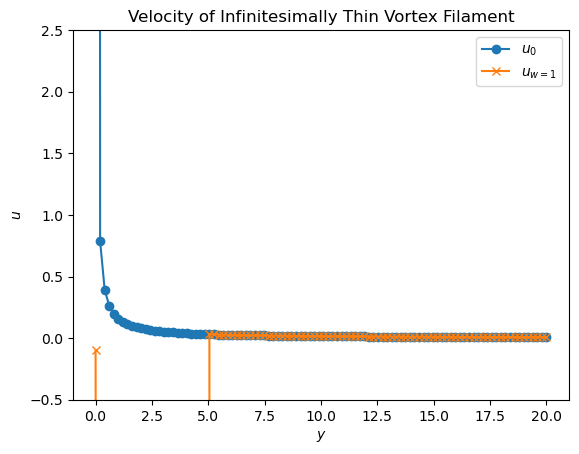

In [24]:
# Testing that the Bio-Savart law with the weight
# function works

# We can't start at 0, however we use it here so the
# divisions are nice numbers, then we change the
# first value to a small number.
y_vec = np.linspace(0, 20, 100)
y_vec[0] = 1e-3
u_0true_vec = 1 / (2 * np.pi * y_vec)

# NOTE: A Bernstein polynomial of degree n whose 
# coefficients are all one is a constant function
# of one.
w = np.ones(3)

# The *w to unpack the weights
u_w_vec = u_w(y_vec, *w)

print('Error =', np.linalg.norm(u_w_vec - u_0true_vec))

plt.plot(y_vec, u_0true_vec, 'o-', label='$u_0$')
plt.plot(y_vec, u_w_vec, 'x-', label='$u_{w=1}$')
plt.legend()
plt.title('Velocity of Infinitesimally Thin Vortex Filament')
plt.xlabel('$y$')
plt.ylabel('$u$')
plt.ylim([-.5, 2.5])
plt.show()


In [41]:
# Fitting the weight function to the Lamb-Oseen vortex

# We can't start at 0, however we use it here so the
# divisions are nice numbers, then we change the
# first value to a small number.
y_vec = np.linspace(0, 5, 100)
y_vec[0] = 1e-3

# u_LO_vec = np.ones_like(y_vec)
u_LO_vec = u_LO(y_vec)

# Initial guess for the weight function.
# Maybe try random initialization?
order = 12
# -4 because we set the first two and last three weights
# and a BS polynomial of degree n has n+1 weights
# w0 = np.zeros(order - 4)
w0 = np.ones(order - 4)
# w0 = np.random.default_rng().uniform(-1, 1, order - 4)
print('w0 =', w0)
optw = sp.optimize.curve_fit(u_w, y_vec, u_LO_vec, p0=w0)[0]
print('optw =', optw)

w0 = [1. 1. 1. 1. 1. 1. 1. 1.]


/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_97968/2011746247.py:21: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  sol = 2 * sp.integrate.quad(integrand, 0, a_co)[0] + (2 / y) - (2 * a_co / (y * np.sqrt(a_co**2 + y**2)))


optw = [0.50085883 0.88583947 1.06141661 1.09456718 1.06712652 1.03163984
 1.00926035 1.00101993]


Error = 2.8977373775107993
Mean Squared Error = 0.2897737377510799


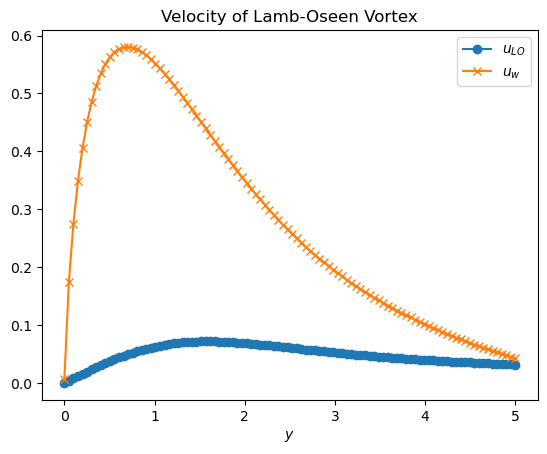

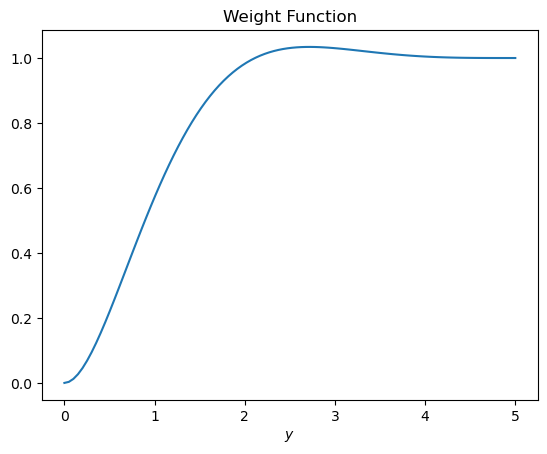

In [42]:
# Plot results
bp = BernsteinPolynomial(order)
bp.set_weights(np.concatenate([[0, 0], optw, [1, 1, 1]]))
wf_vec = np.array([bp(y/5) for y in y_vec])

u_w_vec = u_w(y_vec/5, *optw)
print('Error =', np.linalg.norm(u_w_vec - u_LO_vec))
print('Mean Squared Error =', np.sqrt(np.mean((u_w_vec - u_LO_vec)**2)))

plt.plot(y_vec, u_LO_vec, 'o-', label='$u_{LO}$')
plt.plot(y_vec, u_w_vec, 'x-', label='$u_w$')
plt.legend()
plt.title('Velocity of Lamb-Oseen Vortex')
plt.xlabel('$y$')
plt.show()

plt.plot(y_vec, wf_vec, label='$w$')
plt.title('Weight Function')
plt.xlabel('$y$')
plt.show()